In [96]:
from pathlib import Path
import matplotlib
import math
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import sys
sys.path.append('../../../utility/python/')
from utility import (
    semi_join, anti_join, preprocess_web_logs_screen_name, complement_data,
    sub_days, plus_day, add_group_num, plot_two_axis_bar_line,plus_month
)
from utility import load_web_logs_from_bigquery, load_daily_user_logs_from_bigquery, load_data_from_db_with_script

In [97]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
target_day = '2022-11-03'
target_month = target_day[:7]

In [99]:
data_dir_path = Path('data')
result_dir_path = Path('result')
if not data_dir_path.exists():
    data_dir_path.mkdir(parents=True)
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

In [100]:
excluding_domain_ids = [1, 8, 2095]
privilege_replace_dict = {1: '1_管理職', 2: '2_一般', 3: '2_一般'}
daily_user_logs_name_dict = {
    'deal_board': '案件ボード',
    'deals_table': '案件一覧',
    'actions_table': 'アクション一覧',
    'customers_table': '取引先一覧',
    'contacts_table': 'コンタクト一覧',
    'campaigns_table': 'キャンペーン一覧',
    'webforms_table': 'ウェブフォーム一覧',
    'custom_reports_table': 'カスタムレポート一覧',
    'dashboards_table': 'ダッシュボード一覧',
    'deal_page': '案件ページ',
    'action_page': 'アクションページ',
    'customer_page': '取引先ページ',
    'contact_page': 'コンタクトページ',
    'campaign_page': 'キャンペーンページ',
    'webform_page': 'ウェブフォームページ',
    'custom_report_page': 'カスタムレポートページ',
    'dashboard_page': 'ダッシュボードページ',
    'notification_modal_page': '通知モーダルページ',
    'reports': 'レポート系',
    'customer_merge_candidate': '名寄せ_取引先',
    'contact_merge_candidate': '名寄せ_コンタクト'
}

### データダウンロード

In [101]:
domain_user_maps = pd.read_csv('domain_user_maps.csv')
daily_user_logs = pd.read_csv(data_dir_path.joinpath('daily_user_logs.tsv'), sep = '\t')

#### 前処理
マツリカユーザー削除・契約タイプ制限・dateをdatetime型へ変換

In [102]:
domain_user_maps = anti_join(domain_user_maps, pd.DataFrame({'domain_id': excluding_domain_ids}), by='domain_id')
domain_user_maps = domain_user_maps.query('use_type == 30|use_type == 40').assign(
    contract_start_date = lambda x: x.contract_start_date.astype(str)
)

daily_user_logs = pd.merge(
    daily_user_logs,
    domain_user_maps[['domain_id', 'user_id', 'privilege', 'contract_start_date']],
    on = 'user_id', how = 'inner'
).query('date >= contract_start_date', engine='python')
daily_user_logs.head()

,date,user_id,login_web,login_mobile,deal_board,deals_table,actions_table,customers_table,contacts_table,campaigns_table,webforms_table,custom_reports_table,dashboards_table,deal_page,action_page,customer_page,contact_page,campaign_page,webform_page,custom_report_page,dashboard_page,notification_modal_page,reports,domain_id,privilege,contract_start_date
0,2022-03-16,10225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1581,1,2020-06-01
1,2022-03-13,10225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1581,1,2020-06-01
2,2022-04-07,10225,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1581,1,2020-06-01
3,2022-03-23,10225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1581,1,2020-06-01
4,2022-04-17,10225,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1581,1,2020-06-01


### 結合させたデータ

In [103]:
wau = daily_user_logs.query('login_web == 1', engine='python')[['date', 'user_id', 'login_web']].assign(
    date = lambda x:pd.to_datetime(daily_user_logs['date'])
)
wau['date'] = pd.to_datetime(wau['date'])
wau['date'] = wau['date'].dt.to_period('W').dt.start_time 
wau['date'] = wau['date'].astype(str)

In [111]:
wau_data = wau.pivot_table(values = ['login_web'], index = ['user_id'], columns = ['date'], aggfunc = 'sum' , fill_value = 0)
wau_data.columns = list(map(lambda x: f'{x[1]}', wau_data.columns))
wau_data1 = wau_data.iloc[: , wau_data.columns!='user_id'].mask(wau_data >= 1, 1)
wau_data1.head()

,2022-02-28,2022-03-07,2022-03-14,2022-03-21,2022-03-28,2022-04-04,2022-04-11,2022-04-18,2022-04-25,2022-05-02,2022-05-09,2022-05-16,2022-05-23,2022-05-30,2022-06-06,2022-06-13,2022-06-20,2022-06-27,2022-07-04,2022-07-11,2022-07-18,2022-07-25,2022-08-01,2022-08-08,2022-08-15,2022-08-22,2022-08-29,2022-09-05,2022-09-12,2022-09-19,2022-09-26,2022-10-03,2022-10-10,2022-10-17,2022-10-24,2022-10-31
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0
174,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,1
184,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0
574,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
594,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
rate1 = []
rate2 = []
for i in range(len(wau_data1.columns)-1):
   first = wau_data1[wau_data1.iloc[:, i] == 1]
   value = first.iloc[:,i].sum()
   rate2.append(value)
   second = first[first.iloc[:,i+1] == 1]
   rate = second.iloc[:,i].count()/first.iloc[:, i].count()
   rate = round(100-rate*100, 1)
   rate1.append(rate)

In [106]:
plot_data = pd.DataFrame({'date' : wau_data1.columns[1 : -1]})
plot_data['rate'] = pd.DataFrame(rate1)
plot_data['value'] = pd.DataFrame(rate2)

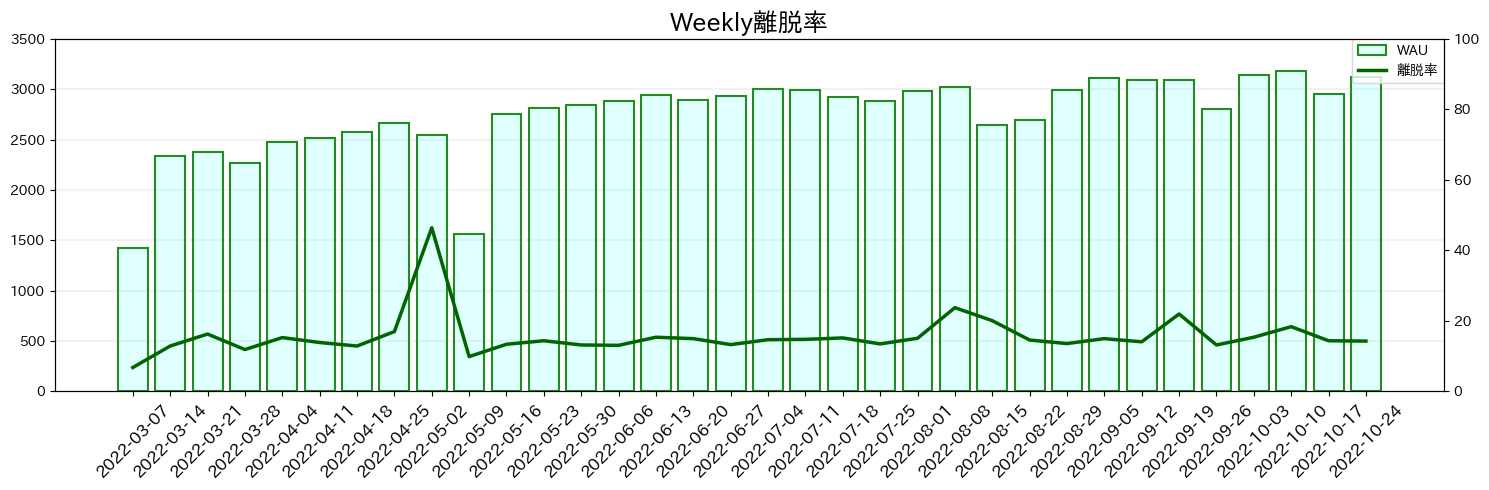

In [107]:
plot_two_axis_bar_line(
    plot_data = plot_data, x='date', 
    y1_dicts = [{'y': 'value', 'label': 'WAU'}],
    y2_dicts = [{'y': 'rate', 'label': '離脱率'}],
    figsize = (15, 5),
    title = 'Weekly離脱率',
    y1_lim = [0, 3500],
    y2_lim = [0, 100],
    xaxis_rotation = 45,
    image_file_path = result_dir_path.joinpath('1weekly離脱率.png')
)

In [108]:
rate3=[]
rate4=[]
for i in range(len(wau_data1.columns)-4):
   first = wau_data1[wau_data1.iloc[:, i] == 1]
   value = first.iloc[:,i].sum()
   rate4.append(value)
   second = first[(first.iloc[:, i+1] == 1) | (first.iloc[:, i+2] == 1) | (first.iloc[:, i+3] == 1)]
   rate = second.iloc[:,i].count()/first.iloc[:, i].count()
   rate = round(100-rate*100, 1)
   rate3.append(rate)

In [109]:
plot_data1 = pd.DataFrame({'date' : wau_data1.columns[ : -4]})
plot_data1 = plot_data1[1:]
plot_data1['rate'] = pd.DataFrame(rate3)
plot_data1['value'] = pd.DataFrame(rate4)

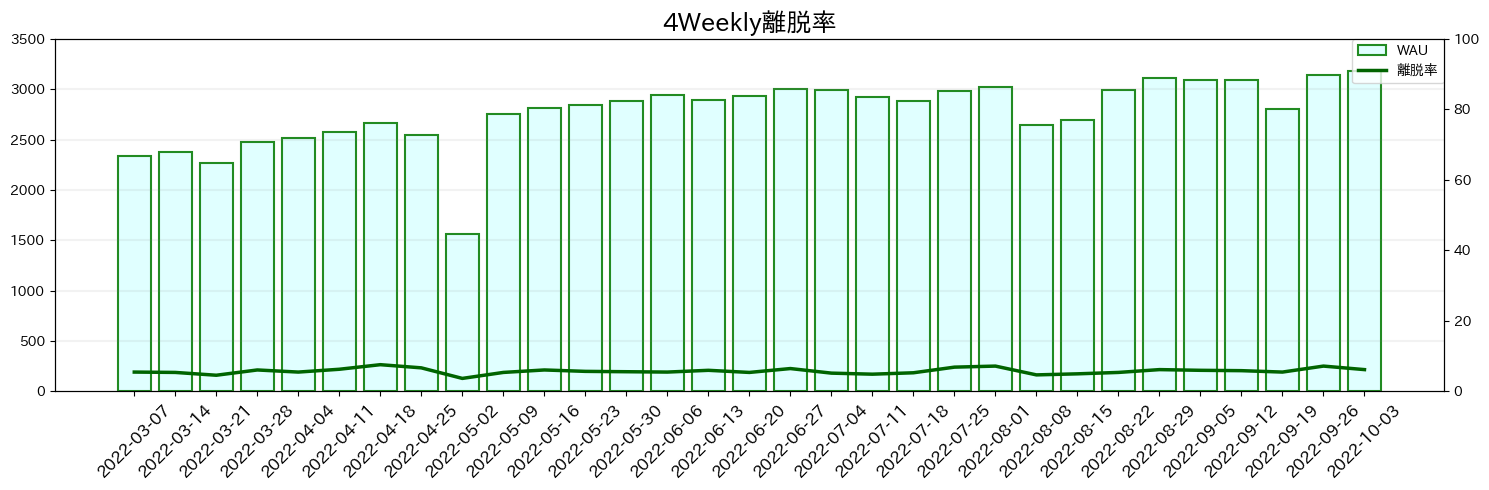

In [110]:
plot_two_axis_bar_line(
    plot_data = plot_data1, x='date', 
    y1_dicts = [{'y': 'value', 'label': 'WAU'}],
    y2_dicts = [{'y': 'rate', 'label': '離脱率'}],
    figsize = (15, 5),
    title = '4Weekly離脱率',
    y1_lim = [0, 3500],
    y2_lim = [0, 100],
    xaxis_rotation = 45,
    image_file_path = result_dir_path.joinpath('4Weekly離脱.png')
)